In [1]:
TTS_PATH = "/local_disk/calypso/jduret/git/Chaanks/TTS/"

In [2]:
#!pip install gruut
#!pip install anyascii
#!pip install jieba
#!pip install pypinyin
#!pip install mecab-python3
#!pip install pyworld

In [3]:
import os
import sys
sys.path.append(TTS_PATH) # set this if TTS is not installed globally
import librosa
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.tts.datasets.formatters import synpaflex
%matplotlib inline

In [4]:
DATA_PATH = "/local_disk/calypso/jduret/corpus/synplaflex"
META_DATA = "/local_disk/calypso/jduret/corpus/synplaflex/metadata.csv"
NUM_PROC = 8

In [5]:
# use your own preprocessor at this stage - TTS/datasets/proprocess.py
items = synpaflex(DATA_PATH, META_DATA)
print(" > Number of audio files: {}".format(len(items)))

 > Number of audio files: 21824


In [6]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = item[1].strip()
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(waf_file)

In [7]:
# show duplicate items
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


In [8]:
def load_item(item):
    file_name = item[1].strip()
    text = item[0].strip()
    audio = librosa.load(file_name, sr=None)
    sr = audio[1]
    audio = audio[0]
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(8) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

/tmp/ipykernel_18072/828820704.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  data = list(tqdm(p.imap(load_item, items), total=len(items)))


  0%|          | 0/21824 [00:00<?, ?it/s]

In [9]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

/tmp/ipykernel_18072/2126754372.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm(data):


  0%|          | 0/21824 [00:00<?, ?it/s]

 > Number of words: 70645


In [10]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

/tmp/ipykernel_18072/1322472053.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm(data):


  0%|          | 0/21824 [00:00<?, ?it/s]

In [11]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

### Avg audio length per char

In [15]:
# for item in data:
#     if item[-1] < 2:
#         print(item)

In [13]:
sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
# sec_per_char /= len(data)
# print(sec_per_char)

In [14]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)

0.0736021192186099
0.021647417556280774


In [16]:
dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    pdf =norm.pdf(sec_per_char)
    if pdf < 0.39:
        print(item)

('/local_disk/calypso/jduret/corpus/synplaflex/wavs/voyagecentreterre_26_027.wav', 'Fin du Chapitre 26.', 19, array([ 0.0000000e+00, -3.0517578e-05,  3.0517578e-05, ...,
       -3.0517578e-05,  0.0000000e+00,  0.0000000e+00], dtype=float32), 6.449478458049887)
('/local_disk/calypso/jduret/corpus/synplaflex/wavs/voyagecentreterre_36_072.wav', 'Fin du chapitre 36.', 19, array([-1.8310547e-04,  6.1035156e-05, -3.0517578e-05, ...,
        3.0517578e-05,  0.0000000e+00,  0.0000000e+00], dtype=float32), 7.5902267573696145)
('/local_disk/calypso/jduret/corpus/synplaflex/wavs/voyagecentreterre_16_047.wav', 'Fin du Chapitre 16.', 19, array([ 1.0375977e-03, -3.6621094e-04,  9.1552734e-05, ...,
        3.0517578e-05,  0.0000000e+00,  0.0000000e+00], dtype=float32), 6.93827664399093)
('/local_disk/calypso/jduret/corpus/synplaflex/wavs/voyagecentreterre_32_062.wav', 'Fin du Chapitre 32.', 19, array([-2.4414062e-04, -3.0517578e-05, -9.1552734e-05, ...,
        0.0000000e+00,  0.0000000e+00,  0.00000

### Plot Dataset Statistics

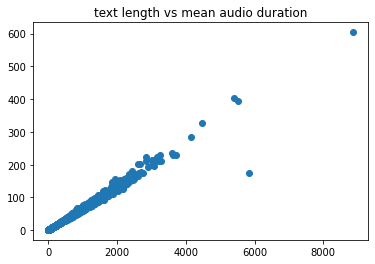

In [17]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

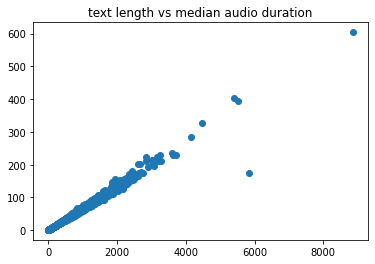

In [18]:
plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

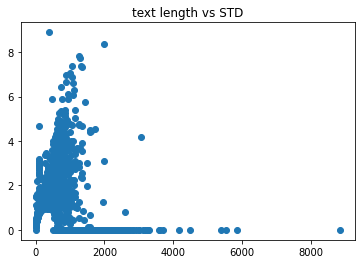

In [19]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

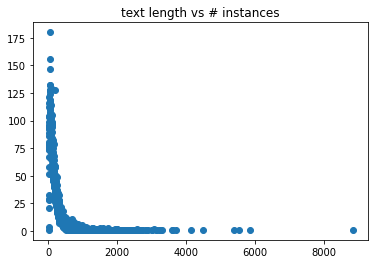

In [20]:
plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

### Check words frequencies

In [ ]:
w_count_df = pd.DataFrame.from_dict(w_count, orient='index')
w_count_df.sort_values(0, ascending=False, inplace=True)

In [ ]:
w_count_df

In [ ]:
# check a certain word
w_count_df.at['minute', 0]

In [ ]:
# fequency bar plot - it takes time!!
w_count_df.plot.bar()